In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json
import urllib.request
import zipfile
import torch

from time import time
from torch import nn, distributions
from scipy.spatial.distance import cdist
from scipy.stats import norm
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

!pip install GPyOpt
import GPyOpt

os.mkdir('figures')

     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 1.0MB 12.7MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83622 sha256=d0c0091acebf544cbcdc6d3eb5b88b0d65f7e569fed36ececf5dbcd61cffc675
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633914 sha256=d7d670582c49b9c5cdf01e5d29ffb55dabcc5f0a7c05912ff34ed7bc2b7fae01
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=75f25171cc3d9a2757dac756053ea3ddb1d22ada19627245796327ac8e3a2916
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPyOpt GPy paramz


# Check GPU

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Data Tools

In [ ]:
def save_to_pickle(data, dir, fname):
    with open(os.path.join(dir, fname), 'wb') as f:
        pickle.dump(data, f)
    print('{} written to pkl'.format(fname))

def load_from_pickle(dir, fname):
    with open(os.path.join(dir,fname), 'rb') as f:
        data = pickle.load(f)
    return data

def downsample_df(df, time_alias):
    ''' daily: 'D' '''
    group = df.resample(time_alias)
    df_resampled = group.sum()
    return df_resampled

def df_impute_previous_index(df, idx_delta, nan_tag): # too slow
    ''' imputes missing values based on prior index in pandas dataframe,
        uses np array for speed. Preserves column names and indices.
        inputs:
            df:         pandas dataframe
            idx_delta:  int, number of indices to find prior value to impute
            nan_tag:    np.nan OR string, e.g. 'nan' or 'na'

        output:
            new_df: pandas dataframe, same size as df '''
    vals = df.values
    for row in range(vals.shape[0]):
        for col in range(vals.shape[1]):
            if vals[row,col] == nan_tag:
                vals[row,col] = vals[row - idx_delta, col]
    new_df = pd.DataFrame(data=vals, index=df.index, columns=df.columns)
    return new_df

# Data

In [ ]:
#Download the data file
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
filehandle, _ = urllib.request.urlretrieve(url)

# Create a ZipFile Object and load filehandle in it
with zipfile.ZipFile(filehandle, 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('data')

In [ ]:
# Clean and downsample data

# LOAD FILE
dir = 'data'
fname = 'household_power_consumption.txt'
dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')

# CLEAN DATA
# replace missing value with nan
dataset.replace('?', np.nan, inplace=True) # could use from numpy import nan, nan
# set data type as int
dataset = dataset.astype('float32')

# impute missing values: value of 24 hours previous
idx_delta = 60*24 #index of 24 hours previous, timeset interval = 1 minute
data_clean = df_impute_previous_index(dataset, idx_delta, np.nan)

# engineer 4th sub_metering feature
data_clean['Sub_metering_4'] = (data_clean.Global_active_power * 1000 / 60) - (data_clean.Sub_metering_1 + data_clean.Sub_metering_2 + data_clean.Sub_metering_3)

# SAVE DATA
save_to_pickle(data_clean, dir, 'data.pkl')

# Downsample to daily values
data_resamp = downsample_df(data_clean, 'D')

# SAVE DATA 
save_to_pickle(data_resamp, dir, 'data_daily.pkl')

data.pkl written to pkl
data_daily.pkl written to pkl


In [ ]:
# Create train and test splits

# LOAD DATA
dir = 'data'
data = load_from_pickle(dir, 'data_daily.pkl')

# SPLIT DATA
# using standard weeks sunday - saturday
# first sunday in dataset:
day1_train = '2006-12-17'
# first sunday in 2010:
day1_test = '2010-1-3'
# last saturday in dataset:
day_last_test = '2010-11-20'

data_train = data[data.index >= day1_train]
data_train = data_train[data_train.index < day1_test]
data_test = data[data.index >= day1_test]
data_test = data_test[data_test.index <= day_last_test]

# METRICS
ndays_train = data_train.shape[0]
ndays_test = data_test.shape[0]
print('\ntraining set duration: {} days, {} weeks'.format(ndays_train, ndays_train/7))
print('test set duration: {} days, {} weeks\n'.format(ndays_test, ndays_test/7))

save_to_pickle(data_train, 'data', 'data_train.pkl')
save_to_pickle(data_test, 'data', 'data_test.pkl')


training set duration: 1113 days, 159.0 weeks
test set duration: 322 days, 46.0 weeks

data_train.pkl written to pkl
data_test.pkl written to pkl


# Train Model

In [ ]:
def build_staggered_Xy_1d(data, feature_idx, n_input=7, n_output=7):
    ''' feature_idx:    int     index of feature in array '''
    X, y = [],[]
    in_start = 0
    # step over timeseries: 'in' and 'out' series, lengths = n_input, n_output
    # series are contiguous so in_end = out_start
    for i in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_output
        if out_end < len(data): # prevent iterating too far
            x_input = data[in_start:in_end, feature_idx]
            x_input = x_input.reshape((len(x_input), 1)) # column vector
            X.append(x_input)
            y.append(data[in_end:out_end, feature_idx])
        # step forward one unit
        in_start += 1

    return np.array(X), np.array(y)

def build_model(X_train, y_train):
    # define parameters
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    return model

def walk_forward_validation(data, model, n_input, n_output):
    ''' walk-forward validation
        advances one unit at a time for a fixed set (e.g. daily, by week)
        inputs
            data        np array    must be shape that model has been trained on
            model       keras model with .predict() method and verbose parameter
            n_input     int         number of units to include in each input set
        outputs
            true        list        true values
            pred        list        predicted values, same length as true
        caveats
            data must match shape that model was trained on
            model must be trained on same n_input

    '''
    true = []
    pred = []
    c = 0
    for i in range(len(data) - (n_input+n_output)):
        input = data[c:c + n_input]
        input = input.reshape(1, len(input), 1)
        y_true = data[c + n_input: c + n_input + n_output]
        y_hat = model.predict(input, verbose=0)
        true.append(y_true)
        pred.append(y_hat.squeeze()) # drop one dimension
        c += 1

    return true, pred

def calc_rmse_error(true, pred):
    ''' calc mse error from lists of true and predicted values
        uses sklearn.metrics.mean_squared_error()
        input lists can contain ints or arrays'''
    errors = []
    for y_true, y_hat in zip(true, pred):
        mse = mean_squared_error(y_true, y_hat)
        rmse = np.sqrt(mse)
        errors.append(rmse)

    return np.array(errors)

In [ ]:
def train_model(timeWindow):
  #Get train and test data
  train_df = load_from_pickle('data','data_train.pkl')
  test_df = load_from_pickle('data','data_test.pkl')

  # TRANSFORM to np array
  # columns: ['Global_active_power', 'Global_reactive_power', 'Voltage',
  #   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
  #   'Sub_metering_3', 'Sub_metering_4']
  train_data = train_df.values
  test_data = test_df.values

  # convert timeseries into staggered inputs and outputs
  X_train, y_train = build_staggered_Xy_1d(train_data, feature_idx=0, n_input=timeWindow, n_output=7)

  # train the model
  model = build_model(X_train, y_train)

  # fit network
  verbose, epochs, batch_size = 0, 20, 4
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

  return model

def evaluate_model(model,timeWindow, saveOutput=False):
  model.compile(loss='mse', optimizer='adam')

  test_df = load_from_pickle('data', 'data_test.pkl')
  test = test_df.values

  # evaluate on test set: univariate
  feat_col = 0
  test = test[:,feat_col]
  true, pred = walk_forward_validation(test, model, n_input=timeWindow, n_output=7)

  # score predictions, save to file
  errors = calc_rmse_error(true, pred)
  if saveOutput:
    save_to_pickle((true, pred, errors), 'output', 'output_1.pkl')
  
  return (true, pred, errors)

def trainAndEvaluate(timeWindow, saveOutput=False):
  model = train_model(timeWindow)
  (true, pred, _) = evaluate_model(model,timeWindow,saveOutput)

  return np.sqrt(np.average(np.power(np.array(true)-np.array(pred),2)))


In [ ]:
timeWindow = 4
score = trainAndEvaluate(timeWindow, saveOutput=False)
print(score)

475.21436


# GridSearch

In [ ]:
# points that we are considering
X = np.array(range(4,29))

scores = np.zeros((X.shape[0],5))
t0 = time()
for i, timeWindow in enumerate(X):
  for j in range(5):
    scores[i,j] = trainAndEvaluate(timeWindow, saveOutput=False)
t1 = time()


In [ ]:
print('function vers1 takes %f' %(t1-t0))

function vers1 takes 2280.916925


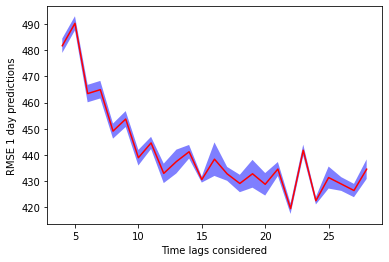

In [ ]:
meanScores = np.average(scores, axis=1)
stdScores = np.std(scores, axis=1)/np.sqrt(5)

fig = plt.figure(1)

plt.fill_between(X, meanScores-stdScores, meanScores+stdScores, facecolor='blue', alpha=0.5)
plt.plot(X,meanScores, color='red')
plt.ylabel('RMSE 1 day predictions')
plt.xlabel('Time lags considered')
plt.show
fig.savefig('figures/gridSearch.png', dpi=fig.dpi)

In [ ]:
print('GridSearch find time lag {} to be the best with a RMSE on the test set of {}'.format(X[np.argmin(meanScores)], np.min(meanScores)))

GridSearch find time lag 22 to be the best with a RMSE on the test set of 419.57073364257815


# Bayesian Optimization


In [ ]:
# number of initial random samples
init_samples = 2

# get some random samples
Xinit = np.reshape(np.array([4,28]),(init_samples,1))
Yinit = []

# get some random samples
for i in range(init_samples):
    # we query the function
    Yinit.append(trainAndEvaluate(Xinit[i,0], saveOutput=False))

Yinit = np.reshape(np.array(Yinit),(init_samples,1))

optimDomain = [{'name': 'timeWindow', 'type': 'discrete', 'domain': (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28)}]

def bo_trainAndEvaluate(timeWindow):
  timeWindow = timeWindow[0][0]
  return trainAndEvaluate(timeWindow, saveOutput=False)

In [ ]:
#‘EI’, expected improvement. 
#‘MPI’, maximum probability of improvement.
#‘LCB’, GP-Lower confidence bound.
acquisitions = ['EI', 'MPI', 'LCB']
jitters = [0.01, 0.1, 1, 10]

for acquisition in acquisitions:
  for jitter in jitters:
    bo = GPyOpt.methods.BayesianOptimization(bo_trainAndEvaluate, domain=optimDomain, X=Xinit, Y=Yinit, normalize_Y=True, acquisition_type=acquisition, acquisition_jitter = jitter, exact_feval=False)
    t0 = time()
    bo.run_optimization(max_iter = 25)
    t1 = time()

    fname = 'figures/plot_aq_' + acquisition + '_' + str(jitter).replace('.','')
    bo.plot_acquisition(fname)
    fname = 'figures/plot_conv_' + acquisition + '_' + str(jitter).replace('.','')
    bo.plot_convergence(fname)

    print('BO with acquisition {} and jitter {} find time lag {} to be the best with a RMSE on the test set of {}'.format(acquisition, jitter, bo.X[np.argmin(bo.Y)], np.min(bo.Y)))
    print('BO with acquisition {} and jitter {} took {} seconds \n'.format(acquisition, jitter, t1-t0))

SyntaxError: ignored